## **Step - 1: Data Collection**

In [36]:
import pandas as pd

# Load both datasets
df_16 = pd.read_csv("https://raw.githubusercontent.com/chaitanya-0b10/ML-Project-/refs/heads/main/coin_gecko_2022-03-16.csv")
df_17 = pd.read_csv("https://raw.githubusercontent.com/chaitanya-0b10/ML-Project-/refs/heads/main/coin_gecko_2022-03-17.csv")

# Combine the datasets
df = pd.concat([df_16, df_17], ignore_index=True)

# Show basic info and head to understand structure
df_info = df.info()
df_head = df.head()

df_info, df_head


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   coin        1000 non-null   object 
 1   symbol      1000 non-null   object 
 2   price       1000 non-null   float64
 3   1h          993 non-null    float64
 4   24h         993 non-null    float64
 5   7d          992 non-null    float64
 6   24h_volume  993 non-null    float64
 7   mkt_cap     1000 non-null   float64
 8   date        1000 non-null   object 
dtypes: float64(6), object(3)
memory usage: 70.4+ KB


(None,
        coin symbol         price     1h    24h     7d    24h_volume  \
 0   Bitcoin    BTC  40859.460000  0.022  0.030  0.055  3.539076e+10   
 1  Ethereum    ETH   2744.410000  0.024  0.034  0.065  1.974870e+10   
 2    Tether   USDT      1.000000 -0.001 -0.001  0.000  5.793497e+10   
 3       BNB    BNB    383.430000  0.018  0.028  0.004  1.395854e+09   
 4  USD Coin   USDC      0.999874 -0.001  0.000 -0.000  3.872274e+09   
 
         mkt_cap        date  
 0  7.709915e+11  2022-03-16  
 1  3.271044e+11  2022-03-16  
 2  7.996516e+10  2022-03-16  
 3  6.404382e+10  2022-03-16  
 4  5.222214e+10  2022-03-16  )

## **Step - 2: Data Preprocessing**

In [37]:
from sklearn.preprocessing import MinMaxScaler

# Step 1: Handle missing values (simple strategy: fill with median)
df[['1h', '24h', '7d', '24h_volume']] = df[['1h', '24h', '7d', '24h_volume']].fillna(df[['1h', '24h', '7d', '24h_volume']].median())

# Step 2: Convert date column to datetime
df['date'] = pd.to_datetime(df['date'])

# Step 3: Drop non-numeric columns not useful for ML modeling directly
df_clean = df.drop(columns=['coin', 'symbol', 'date'])

# Step 4: Normalize numerical features
scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df_clean), columns=df_clean.columns)

# Preview cleaned and normalized data
df_scaled.head()


,price,1h,24h,7d,24h_volume,mkt_cap
0,0.991319,0.908636,0.552739,0.118660,0.610870,0.993446
1,0.066584,0.911139,0.556010,0.120596,0.340877,0.421435
2,0.000024,0.879850,0.527392,0.108014,1.000000,0.102962
3,0.009303,0.903630,0.551104,0.108788,0.024093,0.082445
4,0.000024,0.879850,0.528209,0.108014,0.066838,0.067211


## **Step - 3: EDA**

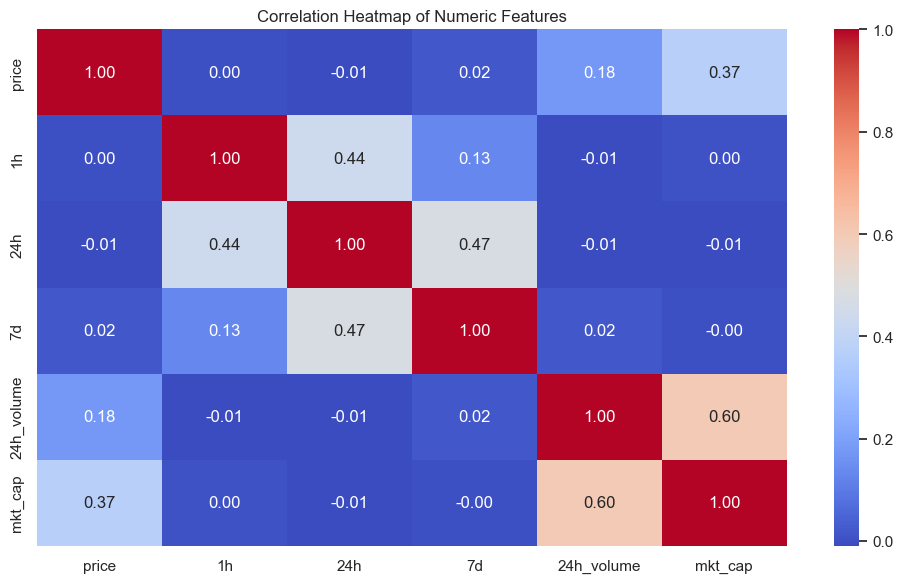

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns

numeric_cols = ['price', '1h', '24h', '7d', '24h_volume', 'mkt_cap']
df_eda = df[numeric_cols]

# Set up plot style
sns.set(style="whitegrid")

# 1. Correlation Heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(df_eda.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap of Numeric Features")
plt.tight_layout()
plt.show()


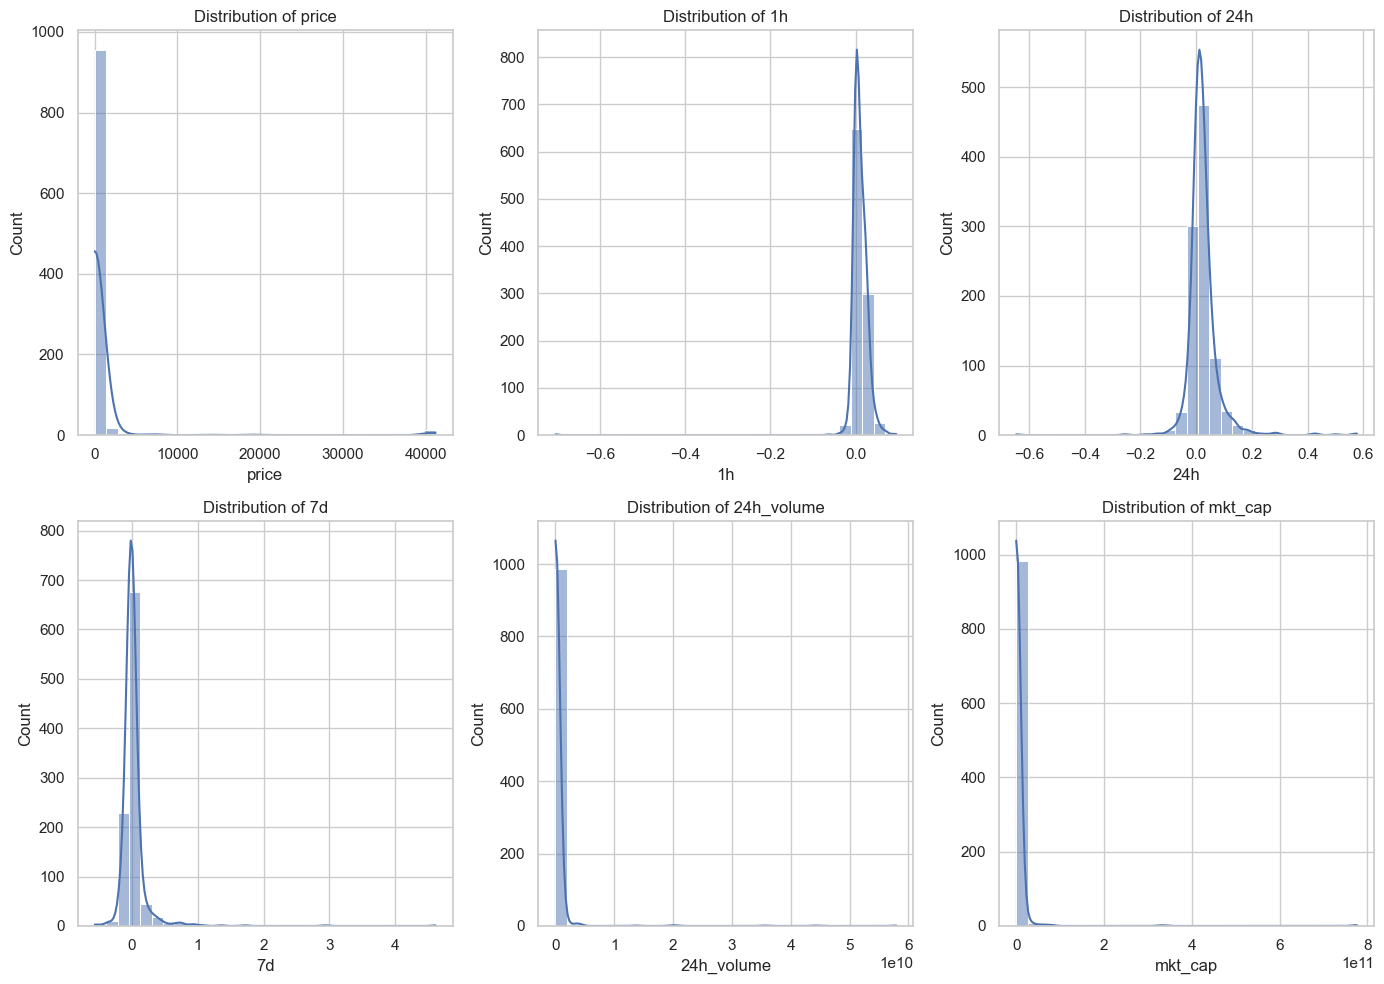

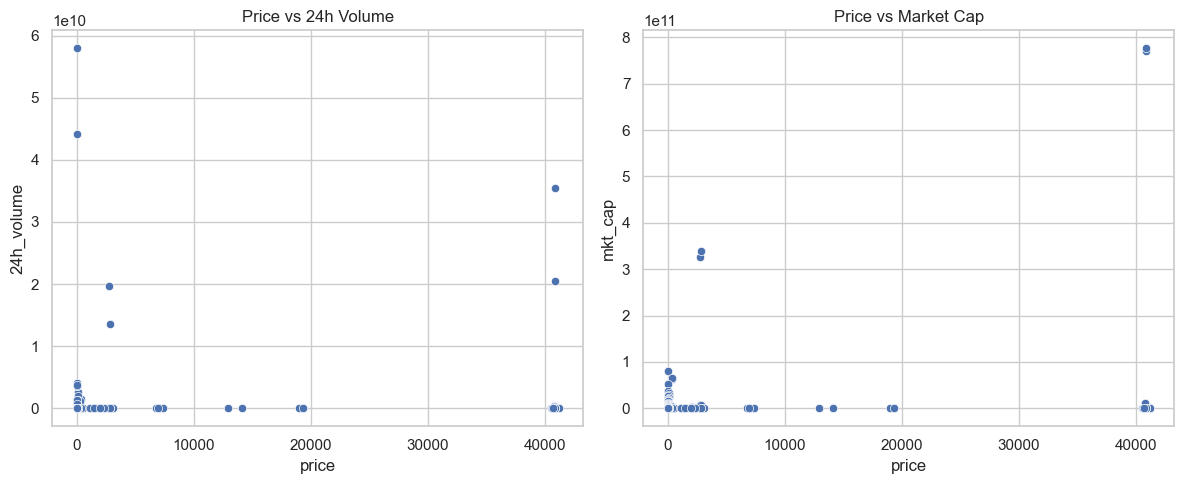

In [39]:
# 2. Distribution Plots of Key Features
plt.figure(figsize=(14, 10))
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(2, 3, i)
    sns.histplot(df_eda[col], kde=True, bins=30)
    plt.title(f"Distribution of {col}")
plt.tight_layout()
plt.show()

# 3. Scatter plots of price vs volume/mkt_cap
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.scatterplot(x='price', y='24h_volume', data=df_eda)
plt.title("Price vs 24h Volume")

plt.subplot(1, 2, 2)
sns.scatterplot(x='price', y='mkt_cap', data=df_eda)
plt.title("Price vs Market Cap")

plt.tight_layout()
plt.show()


## **Steps - 4: Feature Engineering**

In [40]:
df_fe = df.copy()

# Sort by coin and date to maintain temporal order
df_fe.sort_values(by=['coin', 'date'], inplace=True)

# Group by coin to apply rolling operations per cryptocurrency
grouped = df_fe.groupby('coin')

# Moving Averages of Price and Volume
df_fe['price_ma3'] = grouped['price'].transform(lambda x: x.rolling(window=3, min_periods=1).mean())
df_fe['volume_ma3'] = grouped['24h_volume'].transform(lambda x: x.rolling(window=3, min_periods=1).mean())

# Volatility of price and volume (rolling std deviation)
df_fe['price_volatility3'] = grouped['price'].transform(lambda x: x.rolling(window=3, min_periods=1).std().fillna(0))
df_fe['volume_volatility3'] = grouped['24h_volume'].transform(lambda x: x.rolling(window=3, min_periods=1).std().fillna(0))

# Liquidity Ratio = 24h Volume / Market Cap
df_fe['liquidity_ratio'] = df_fe['24h_volume'] / df_fe['mkt_cap']

# Display a preview of the engineered features
df_fe[['coin', 'date', 'price', '24h_volume', 'mkt_cap',
       'price_ma3', 'volume_ma3', 'price_volatility3',
       'volume_volatility3', 'liquidity_ratio']].head(10)


,coin,date,price,24h_volume,mkt_cap,price_ma3,volume_ma3,price_volatility3,volume_volatility3,liquidity_ratio
158,0x,2022-03-16,0.509791,29309302.0,427933388.0,0.509791,29309302.0,0.000000e+00,0.000000e+00,0.068490
659,0x,2022-03-17,0.518160,24224308.0,439124277.0,0.513975,26766805.0,5.917777e-03,3.595634e+06,0.055165
116,1inch,2022-03-16,1.500000,120457113.0,616145134.0,1.500000,120457113.0,0.000000e+00,0.000000e+00,0.195501
622,1inch,2022-03-17,1.490000,64145152.0,617505356.0,1.495000,92301132.5,7.071068e-03,3.981857e+07,0.103878
376,AIOZ Network,2022-03-16,0.237396,13715452.0,114207956.0,0.237396,13715452.0,0.000000e+00,0.000000e+00,0.120092
911,AIOZ Network,2022-03-17,0.214561,5493212.0,103148149.0,0.225978,9604332.0,1.614678e-02,5.814002e+06,0.053256
159,APENFT,2022-03-16,0.000002,69002807.0,421365369.0,0.000002,69002807.0,0.000000e+00,0.000000e+00,0.163760
661,APENFT,2022-03-17,0.000002,52887977.0,426608620.0,0.000002,60945392.0,1.080459e-08,1.139491e+07,0.123973
231,API3,2022-03-16,4.700000,29731985.0,230984150.0,4.700000,29731985.0,0.000000e+00,0.000000e+00,0.128719
733,API3,2022-03-17,4.640000,30688251.0,230330587.0,4.670000,30210118.0,4.242641e-02,6.761822e+05,0.133236


In [41]:
# Sort by coin and date
df.sort_values(by=['coin', 'date'], inplace=True)

# Group by coin for rolling calculations
grouped = df.groupby('coin')

# === Feature Engineering ===

# 1. Moving Averages (3-day window)
df['price_ma3'] = grouped['price'].transform(lambda x: x.rolling(window=3, min_periods=1).mean())
df['volume_ma3'] = grouped['24h_volume'].transform(lambda x: x.rolling(window=3, min_periods=1).mean())

# 2. Volatility (3-day std deviation)
df['price_volatility3'] = grouped['price'].transform(lambda x: x.rolling(window=3, min_periods=1).std().fillna(0))
df['volume_volatility3'] = grouped['24h_volume'].transform(lambda x: x.rolling(window=3, min_periods=1).std().fillna(0))

# 3. Liquidity Ratio
df['liquidity_ratio'] = df['24h_volume'] / df['mkt_cap']


## **Step - 5: Model Selection**
### Random Forest Regressor :- Captures non-linear relations well

In [42]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

## **Step - 6: Model Training**

In [43]:

import numpy as np

# Select features and target
features = [
    'price', '1h', '24h', '7d', '24h_volume', 'mkt_cap',
    'price_ma3', 'volume_ma3', 'price_volatility3', 'volume_volatility3'
]
target = 'liquidity_ratio'

# Drop rows with NaNs (just in case)
df_model = df.dropna(subset=features + [target])

X = df_model[features]
y = df_model[target]

# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)



## **Step - 7: Model Evaluation**

In [44]:
# Evaluation metrics
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R² Score: {r2:.4f}")

RMSE: 0.1685
MAE: 0.0354
R² Score: 0.8745


## **Step - 8: Hyperparameter Tuning**

In [45]:
from sklearn.model_selection import GridSearchCV

# Define parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Setup model
rf = RandomForestRegressor(random_state=42)

# Grid search with 5-fold cross-validation
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=2
)

# Fit
grid_search.fit(X_train, y_train)

# Best parameters and model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Evaluate tuned model
y_pred_tuned = best_model.predict(X_test)
rmse_tuned = np.sqrt(mean_squared_error(y_test, y_pred_tuned))
mae_tuned = mean_absolute_error(y_test, y_pred_tuned)
r2_tuned = r2_score(y_test, y_pred_tuned)

print("Best Parameters:", best_params)
print(f"Tuned RMSE: {rmse_tuned:.4f}")
print(f"Tuned MAE: {mae_tuned:.4f}")
print(f"Tuned R² Score: {r2_tuned:.4f}")


Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best Parameters: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}
Tuned RMSE: 0.2271
Tuned MAE: 0.0412
Tuned R² Score: 0.7721


## **Step - 9: Model Testing & Validation**

In [46]:
import joblib
joblib.dump(best_model, 'Crypto_liquidity_model.pkl')


['Crypto_liquidity_model.pkl']

In [47]:
model = joblib.load('Crypto_liquidity_model.pkl')


In [48]:
import pandas as pd
import numpy as np
from datetime import timedelta

# --- Generate Data for testing ---
coins = ['Bitcoin', 'Ethereum', 'Cardano']
symbols = ['BTC', 'ETH', 'ADA']
dates = pd.date_range(start='2025-05-01', periods=7)

data = []
for coin, symbol in zip(coins, symbols):
    price = 100 + np.random.rand() * 1000
    for date in dates:
        price_change = np.random.normal(0, 5)
        price = max(price + price_change, 1)
        row = {
            'coin': coin,
            'symbol': symbol,
            'date': date,
            'price': round(price, 2),
            '1h': round(np.random.normal(0, 1), 2),
            '24h': round(np.random.normal(0, 5), 2),
            '7d': round(np.random.normal(0, 10), 2),
            '24h_volume': round(abs(np.random.normal(1e8, 5e7)), 2),
            'mkt_cap': round(abs(np.random.normal(1e9, 3e8)), 2)
        }
        data.append(row)

Test_df = pd.DataFrame(data)

# --- Feature Engineering ---
Test_df['date'] = pd.to_datetime(Test_df['date'])
Test_df.sort_values(by=['coin', 'date'], inplace=True)
grouped = Test_df.groupby('coin')

Test_df['price_ma3'] = grouped['price'].transform(lambda x: x.rolling(window=3, min_periods=1).mean())
Test_df['volume_ma3'] = grouped['24h_volume'].transform(lambda x: x.rolling(window=3, min_periods=1).mean())
Test_df['price_volatility3'] = grouped['price'].transform(lambda x: x.rolling(window=3, min_periods=1).std().fillna(0))
Test_df['volume_volatility3'] = grouped['24h_volume'].transform(lambda x: x.rolling(window=3, min_periods=1).std().fillna(0))

# --- Make Predictions 
X_fake = Test_df[[
    'price', '1h', '24h', '7d', '24h_volume', 'mkt_cap',
    'price_ma3', 'volume_ma3', 'price_volatility3', 'volume_volatility3'
]]

Test_df['predicted_liquidity_ratio'] = best_model.predict(X_fake)

# --- Show Output ---
print(Test_df[['coin', 'date', 'price', 'predicted_liquidity_ratio']].head(10))


       coin       date   price  predicted_liquidity_ratio
0   Bitcoin 2025-05-01  227.79                   1.365648
1   Bitcoin 2025-05-02  229.57                   0.274572
2   Bitcoin 2025-05-03  221.54                   1.541889
3   Bitcoin 2025-05-04  218.07                   0.191034
4   Bitcoin 2025-05-05  211.52                   0.107436
5   Bitcoin 2025-05-06  220.92                   0.004278
6   Bitcoin 2025-05-07  227.82                   1.249255
14  Cardano 2025-05-01  372.79                   0.166985
15  Cardano 2025-05-02  373.89                   0.037131
16  Cardano 2025-05-03  378.12                   1.490351


In [49]:
import gradio as gr
import pandas as pd
import numpy as np
import joblib
from datetime import timedelta

# Load the trained model
# Ensure the model file 'Crypto_liquidity_model.pkl' is in the correct path
try:
    model = joblib.load('Crypto_liquidity_model.pkl')
    print("Model loaded successfully!")
except FileNotFoundError:
    print("Error: 'Crypto_liquidity_model.pkl' not found. Please ensure the model is trained and saved.")
    
except Exception as e:
    print(f"An error occurred loading the model: {e}")
    model = None # Ensure model is None if loading fails


def predict_liquidity(price, h1, h24, d7, volume_24h, mkt_cap):
    if model is None:
        return "Error: Model not loaded. Cannot make predictions."

    # Create a dictionary for the input data
    input_data = {
        'price': [price],
        '1h': [h1],
        '24h': [h24],
        '7d': [d7],
        '24h_volume': [volume_24h],
        'mkt_cap': [mkt_cap],
        # For simplicity in this GUI, we'll calculate basic features based on the single input point.
        'price_ma3': [price],  
        'volume_ma3': [volume_24h], 
        'price_volatility3': [0],
        'volume_volatility3': [0] 
    }

    # Create a DataFrame
    input_df = pd.DataFrame(input_data)


    # Ensure feature order matches the model's training data
    features = [
        'price', '1h', '24h', '7d', '24h_volume', 'mkt_cap',
        'price_ma3', 'volume_ma3', 'price_volatility3', 'volume_volatility3'
    ]

    # Reindex the input dataframe to match the training features order
    try:
        input_df = input_df[features]
    except KeyError as e:
        return f"Error: Missing expected feature in input data: {e}"


    # Predict
    try:
        prediction = model.predict(input_df)[0]
        return f"Predicted Liquidity Ratio: {prediction:.6f}"
    except Exception as e:
        return f"An error occurred during prediction: {e}"


iface = gr.Interface(
    fn=predict_liquidity,
    inputs=[
        gr.Number(label="Price"),
        gr.Number(label="1h Change (%)"),
        gr.Number(label="24h Change (%)"),
        gr.Number(label="7d Change (%)"),
        gr.Number(label="24h Volume"),
        gr.Number(label="Market Cap")
    ],
    outputs="text",
    title="Crypto Liquidity Ratio Predictor",
    description="Enter the current metrics for a cryptocurrency to predict its liquidity ratio."
)

iface.launch(share=True)


Model loaded successfully!
* Running on local URL:  http://127.0.0.1:7864

Could not create share link. Please check your internet connection or our status page: https://status.gradio.app.
